In [2]:
#essential libraries (avoid duplicate installations)
%pip install numpy pandas tensorflow keras keras_tuner scikit-learn matplotlib seaborn plotly yfinance statsmodels arch

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

import time
from datetime import datetime
from itertools import product
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import Hyperband
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px

%matplotlib inline
sns.set_theme(context="notebook", style="darkgrid")

from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocessing import Pool
from scipy.stats import zscore
from tabulate import tabulate

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Fetching data
stock_symbol = "GOOGL"

# Start and end dates
start_date = "2008-09-01"
end_date = "2024-11-01"

# Fetching stock data
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
# Handling missing values
stock_data.dropna(inplace=True)
stock_data.interpolate(inplace=True)

# Display basic information about the dataset
print(f"Data Info for {stock_symbol}:")
print(stock_data.info())

# Data normalization for 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices = stock_data['Close'].values.reshape(-1, 1)
scaled_data = scaler.fit_transform(close_prices)

Data Info for GOOGL:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4070 entries, 2008-09-02 to 2024-10-31
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Adj Close, GOOGL)  4070 non-null   float64
 1   (Close, GOOGL)      4070 non-null   float64
 2   (High, GOOGL)       4070 non-null   float64
 3   (Low, GOOGL)        4070 non-null   float64
 4   (Open, GOOGL)       4070 non-null   float64
 5   (Volume, GOOGL)     4070 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 222.6 KB
None


In [57]:
# Data Description
statisticsChart = stock_data.describe().style.set_caption(f"{stock_symbol} Stock Statistics Summary")\
                                            .format("{:.2f}")\
                                            .background_gradient(cmap='PiYG')
display(statisticsChart)
print("\n")

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
count,4070.00,4070.00,4070.00,4070.00,4070.00,4070.00
mean,55.81,56.01,56.57,55.42,55.99,66414745.50
std,45.42,45.57,46.06,45.08,45.55,63451115.87
min,6.42,6.44,6.74,6.19,6.57,9312000.00
25%,16.88,16.94,17.00,16.71,16.85,28339150.00
50%,39.84,39.99,40.20,39.69,39.99,41221000.00
75%,79.49,79.78,80.74,78.83,79.58,83966949.00
max,190.71,191.18,191.75,189.03,190.31,648938412.00


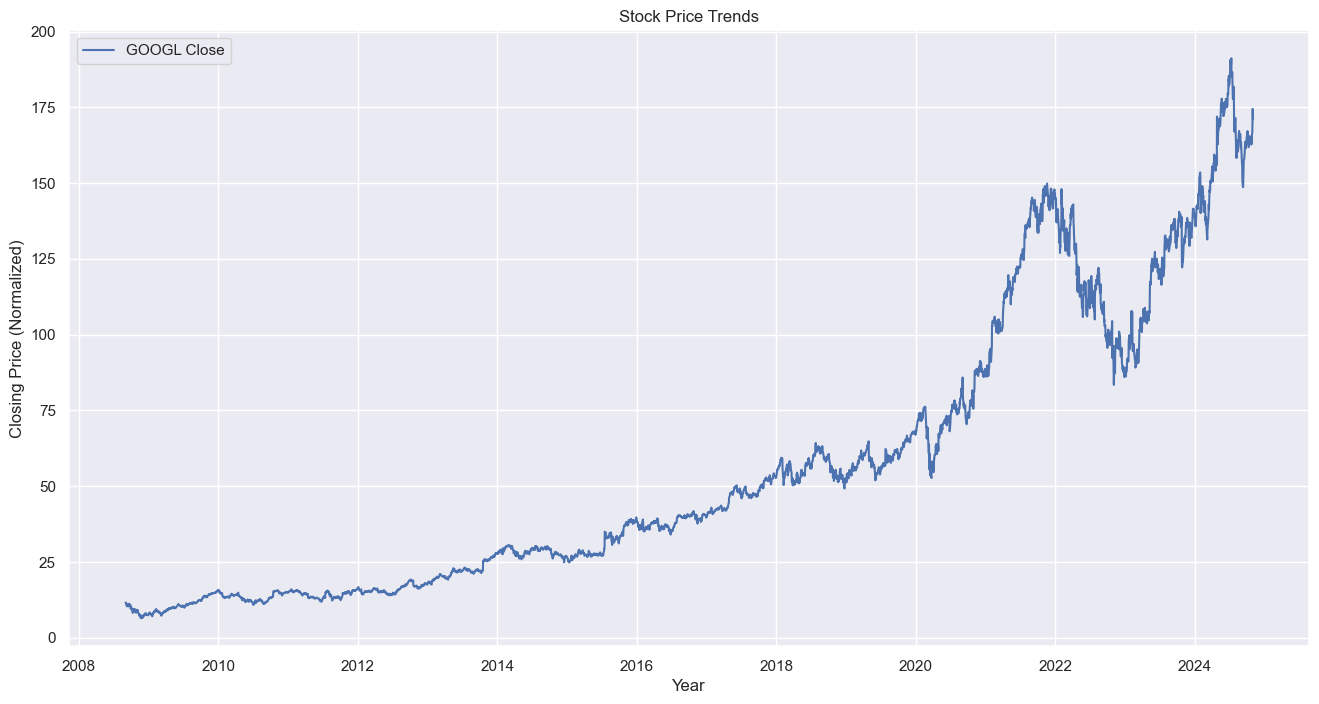

In [58]:
# Stock Price Trends
plt.figure(figsize=(16, 8))
plt.plot(stock_data.index, stock_data['Close'], label=f'{stock_symbol} Close')
plt.title('Stock Price Trends')
plt.xlabel('Year')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()

In [59]:
# Data preparation function
# Create datasets with time steps
def create_dataset(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Create train and test datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create datasets with time steps
time_steps = 60
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

In [80]:
# Define Vanilla RNN, GRU, LSTM Models
def build_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(50, return_sequences=True, input_shape=input_shape))
    model.add(SimpleRNN(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=input_shape))
    model.add(GRU(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# Train Models
def train_model(model, X_train, y_train, X_val, y_val):
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[es])
    return model, history

In [61]:
# Train-test split for validation
X_train_full, X_val, y_train_full, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [81]:
input_shape = (X_train.shape[1], X_train.shape[2])


In [ ]:
# Vanilla RNN Model
rnn_model = build_rnn_model(input_shape)
rnn_model, rnn_history = train_model(rnn_model, X_train_full, y_train_full, X_val, y_val)

In [62]:
# GRU Model
gru_model = build_gru_model(input_shape)
gru_model, gru_history = train_model(gru_model, X_train_full, y_train_full, X_val, y_val)


2024-12-11 23:28:28.609319: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-12-11 23:28:28.609343: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-12-11 23:28:28.609356: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-12-11 23:28:28.609378: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-11 23:28:28.609399: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-12-11 23:28:29.191690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0090 - val_loss: 4.1059e-05
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.6050e-05 - val_loss: 3.8847e-05
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.1840e-05 - val_loss: 3.9473e-05
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.5366e-05 - val_loss: 3.4662e-05
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.2250e-05 - val_loss: 3.4144e-05
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2.6221e-05 - val_loss: 3.3898e-05
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.8145e-05 - val_loss: 3.2528e-05
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.2382e-05 - val_loss: 3.1600e-05
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.5744e-05 - val_loss: 3.3496e-05
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.6137e-05 - val_loss: 3.7136e-05
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.1469e-05 - val_loss: 2

In [63]:
# LSTM Model
lstm_model = build_lstm_model(input_shape)
lstm_model, lstm_history = train_model(lstm_model, X_train_full, y_train_full, X_val, y_val)


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0087 - val_loss: 8.3195e-05
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 7.7745e-05 - val_loss: 8.4251e-05
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 7.1867e-05 - val_loss: 8.6499e-05
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 8.6460e-05 - val_loss: 8.4159e-05
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 8.1170e-05 - val_loss: 8.0810e-05
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 6.5884e-05 - val_loss: 7.9961e-05
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 7.7056e-05 - val_loss: 9.5370e-05
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 7.1381e-05 - val_loss: 1.2084e-04
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 9.2162e-05 - val_loss: 8.0849e-05
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 6.8345e-05 - val_loss: 8.2044e-05
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 7.2006e-05 - 

In [70]:
# Evaluate Models
def evaluate_model(model, X_test, y_test, scaler):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    mse = mean_squared_error(y_test_actual, predictions)
    mae = mean_absolute_error(y_test_actual, predictions)
    rmse = np.sqrt(mse)
    return mse, mae, rmse, predictions, y_test_actual

In [ ]:
# Vanilla RNN Model
rnn_model = build_rnn_model(input_shape)
rnn_model, rnn_history = train_model(rnn_model, X_train_full, y_train_full, X_val, y_val)

In [71]:
# GRU Evaluation
gru_mse, gru_mae, gru_rmse, gru_predictions, y_test_actual = evaluate_model(gru_model, X_test, y_test, scaler)
print(f"GRU Model - MSE: {gru_mse}, MAE: {gru_mae}, RMSE: {gru_rmse}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
GRU Model - MSE: 6.6226627187407665, MAE: 1.9152488910867302, RMSE: 2.5734534615455487


In [72]:
# LSTM Evaluation
lstm_mse, lstm_mae, lstm_rmse, lstm_predictions, y_test_actual = evaluate_model(lstm_model, X_test, y_test, scaler)
print(f"LSTM Model - MSE: {lstm_mse}, MAE: {lstm_mae}, RMSE: {lstm_rmse}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
LSTM Model - MSE: 8.979239658817487, MAE: 2.2715200631624826, RMSE: 2.9965379454993535


In [ ]:
# Vanilla RNN Evaluation
rnn_mse, rnn_mae, rnn_rmse, rnn_predictions, y_test_actual = evaluate_model(rnn_model, X_test, y_test, scaler)
print(f"Vanilla RNN Model - MSE: {rnn_mse}, MAE: {rnn_mae}, RMSE: {rnn_rmse}")

In [73]:
# Plot Predictions
def plot_predictions(y_actual, predictions, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_actual, label='Actual Prices', color='blue')
    plt.plot(predictions, label='Predicted Prices', color='red')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

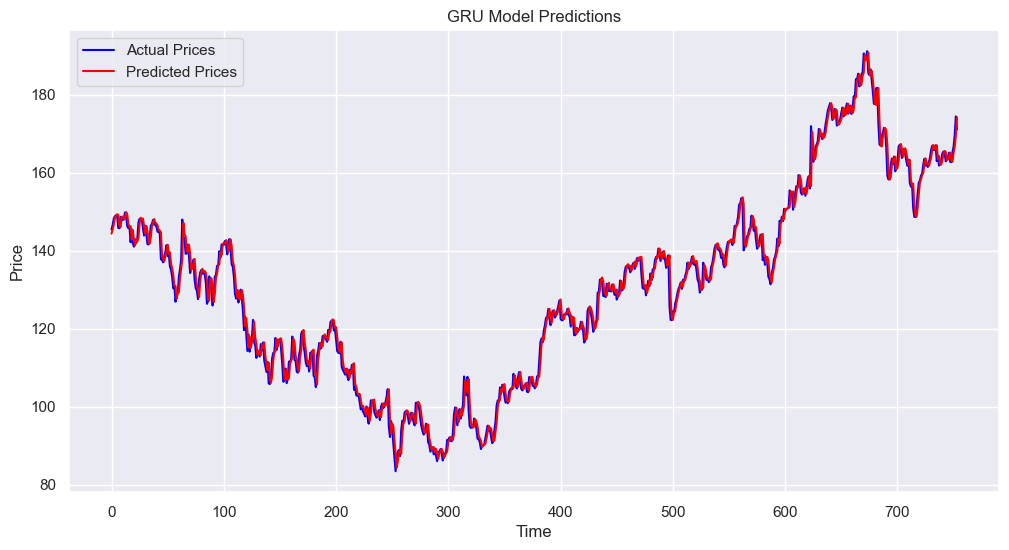

In [74]:
plot_predictions(y_test_actual, gru_predictions, "GRU Model Predictions")


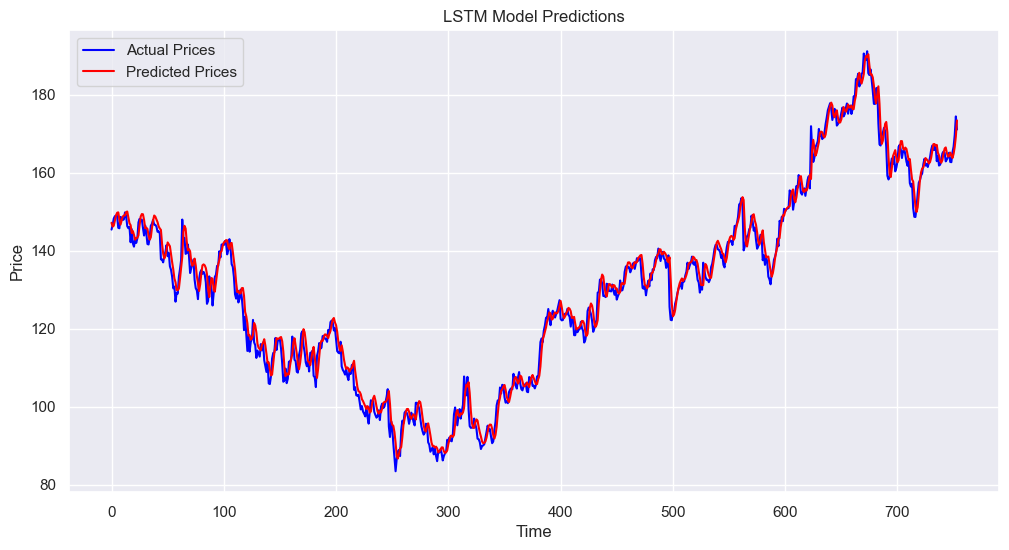

In [75]:
plot_predictions(y_test_actual, lstm_predictions, "LSTM Model Predictions")


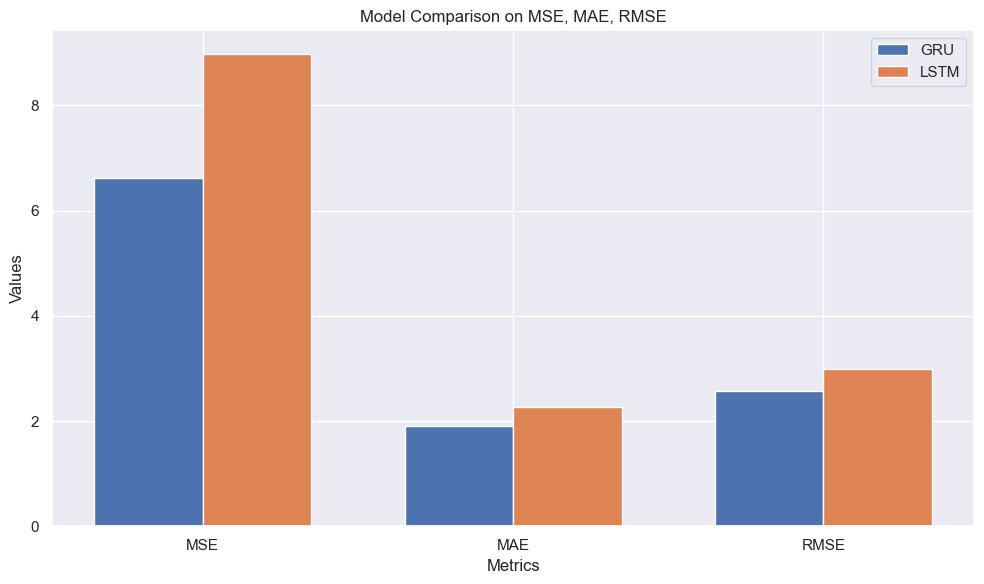

In [76]:
# Model Comparison Chart
def plot_model_comparison(metrics):
    labels = ['MSE', 'MAE', 'RMSE']
    gru_values = [metrics['GRU']['MSE'], metrics['GRU']['MAE'], metrics['GRU']['RMSE']]
    lstm_values = [metrics['LSTM']['MSE'], metrics['LSTM']['MAE'], metrics['LSTM']['RMSE']]

    x = np.arange(len(labels))  # label locations
    width = 0.35  # bar width

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, gru_values, width, label='GRU')
    ax.bar(x + width/2, lstm_values, width, label='LSTM')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title('Model Comparison on MSE, MAE, RMSE')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.tight_layout()
    plt.show()

# Collect Metrics for Chart
metrics = {
    'GRU': {'MSE': gru_mse, 'MAE': gru_mae, 'RMSE': gru_rmse},
    'LSTM': {'MSE': lstm_mse, 'MAE': lstm_mae, 'RMSE': lstm_rmse}
}

plot_model_comparison(metrics)

In [79]:
# Predict Future Prices (Next 7 Days)
def predict_future_prices(model, last_sequence, scaler, days=7):
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(days):
        prediction = model.predict(current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1]))
        future_predictions.append(prediction[0, 0])
        # Update current sequence with the new prediction
        current_sequence = np.append(current_sequence[1:], prediction, axis=0)

    # Transform predictions back to original scale
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_predictions.flatten()

# Last sequence from the training data
test_last_sequence = X_test[-1]

# Predict next 7 days using LSTM model
future_prices_lstm = predict_future_prices(lstm_model, test_last_sequence, scaler, days=7)

print("Predicted stock prices for the next 7 days (LSTM):")
print(future_prices_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted stock prices for the next 7 days (LSTM):
[173.41795 174.90294 175.56967 175.86441 175.96425 175.97287 175.96017]
